In [1]:
import statsmodels.api as sm
from scipy.stats import poisson

Read samples

In [2]:
data_dir="../../../"
indir = "{}/sex_chromosome_coverage".format(data_dir)
with open("{}/Samples".format(indir), "r") as sf:
    samples = [line.strip() for line in sf]

Read sexual chromosome strings

In [3]:
sp2chrom = {}
with open("../../data/Species_to_chromosomes.txt", "r") as fh:
    for line in fh:
        sp, chrX, chrY = line.split()
        sp2chrom[sp] = [chrX, chrY]

Read depths across genomic windows

In [4]:
depths = pd.DataFrame()
for s in samples:
    dp_df = pd.read_csv("{}/depth/{}.regions.bed.gz".format(indir, s), sep="\t", header=None)
    dp_df.columns = ["chrom","start","end","dp"]
    sp = s.split(".")[0]
    dp_df["chrom"] = ["A" if c not in sp2chrom[sp] else "X" if sp2chrom[sp][0]==c else "Y" for c in dp_df.chrom]
    dp_df["indiv"] = s
    depths = pd.concat([depths, dp_df], axis=0)
    
depths["l"] = depths.end - depths.start
depths = depths[depths.l>500e3].reset_index(drop=True)

Normalize data and get sex of individual

In [5]:
# Norm and Poisson p-val
autosome_mean = depths[depths.chrom=="A"].groupby("indiv")["dp"].mean().to_dict()
sexchrom_mean = depths[depths.chrom=="X"].groupby("indiv")["dp"].mean().to_dict()
depths["norm_dp"] = [r.dp/autosome_mean[r.indiv] for i,r in depths.iterrows()]
depths["pval"] = [1-poisson.cdf(autosome_mean[r.indiv], r.dp) for i,r in depths.iterrows()]
depths["bool_pval"] = [p<=0.05 for p in depths.pval]
depths_x = depths[(depths.chrom=="X")]

# Sex of individual
pd.options.mode.chained_assignment = None
config = pd.read_csv("{}/config_file.tsv".format(indir),sep="\t",header=None)
config.columns = ["indiv","lane","rep","fastq","sex"]
config["indiv_rep"] = ["{}.{}".format(i,l) for i,l in zip(config.indiv, config.lane)]
indiv2sex = config.set_index("indiv_rep")["sex"].to_dict()
depths_x["sex"] = [indiv2sex[r.indiv] for i,r in depths_x.iterrows()]

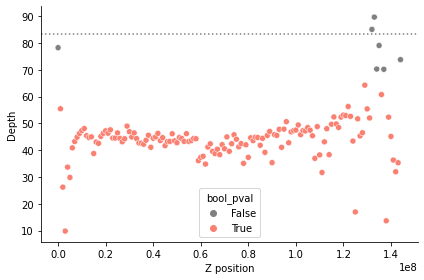

In [6]:
f,ax = plt.subplots()
indiv = "Thamnophis_elegans.i1"
subd = depths[(depths.indiv==indiv) & (depths.chrom=="X")]
sns.scatterplot(data=subd, x="start",y="dp",hue="bool_pval",palette={True:"salmon",False:"gray"})

ax.axhline(autosome_mean[indiv],linestyle="dotted",color="gray")

ax.set_xlabel("Z position")
ax.set_ylabel("Depth")

sns.despine()
plt.tight_layout()
#plt.savefig("../pdfs/Figure_SX_Thamnophis_sirtalis_PAR_poisson.pdf")